In [ ]:
# # Downloading the GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

# Twitter US Airline Sentiment
## Analyze how travelers in February 2015 expressed their feelings on Twitter

---

A Natural Language Processing task using the [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) from Kaggle.

The task consists in classifying "how travelers expressed their feelings on Twitter" into three classes: neutral, positive and negative.



## Loading useful libraries and modules


In [1]:
import itertools
import os
import random
import re
import string

from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from contractions import CONTRACTION_MAP 

# Reproducible results
os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

sns.set(style='white')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

In [2]:
# Downloads from NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data and performing exploratory data analysis

In [3]:
data = pd.read_csv('Tweets.csv', usecols=['airline_sentiment', 'text'])
data = data.loc[:, ['text', 'airline_sentiment']]
data.rename(columns={'text': 'raw_text', 'airline_sentiment': 'sentiment'}, inplace=True)

In [4]:
data.head()

,raw_text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [5]:
print(f'This dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

This dataset has 14640 rows and 2 columns.


In [6]:
# Show a concise summary of a DataFrame
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_text   14640 non-null  object
 1   sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 3.3 MB


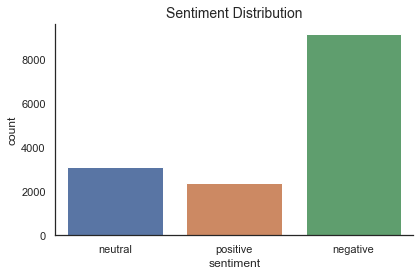

In [7]:
sns.countplot(data['sentiment'])
plt.title('Sentiment Distribution', fontsize=14)
sns.despine()
plt.tight_layout();

## Preprocessing the raw data

* Removing urls, hashtags, handles
* Expanding english contractions
* Removing numbers, punctuation
* Lowercasing
* Removing stop words
* Stemming or lemmatization
* Tokenizing sentences

In [8]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [9]:
def preprocess_text(corpus):

    # Remove hyperlinks    
    text = re.sub(r'https?://\S+|www\.\S+', ' ', corpus)
    
    # Remove hashtags
    text = re.sub(r'#', ' ', text)

    # Remove RT
    text = re.sub(r'^RT[\s]+', ' ', text)

    # Expand english contractions
    text = expand_contractions(text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove special characters    
    pattern = re.compile(r'([{.(-)!}])')
    text = pattern.sub(" \\1 ", text)
  
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)

    # Tokenize, lowercasing, remove handles
    tknzr = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,  
                           reduce_len=True)

    tokens = tknzr.tokenize(text)    

    # Remove stop words
    english_stop_words = stopwords.words('english')
    # punctuation = string.punctuation
    tokens = [token for token in tokens if (token not in english_stop_words)] # and (token not in punctuation)]

    # tokens = [token for token in tokens if token.isalpha()]

    # Stemming
    # stemmer = PorterStemmer()
    # tokens  = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens]

    ## Remove single characters	
    tokens = [token for token in tokens if len(token) > 1]    

    return ' '.join(tokens)

In [10]:
%%time
data['text'] = data['raw_text'].apply(preprocess_text)

Wall time: 11.9 s


In [11]:
data.head()

,raw_text,sentiment,text
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,virginamerica plus added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,virginamerica today must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse
4,@VirginAmerica and it's a really big bad thing about it,negative,virginamerica really big bad thing


In [12]:
text = ' '.join([sentence for sentence in data['text']])
frequence = Counter(text.split())
print(f'This dataset after cleaning has {len(frequence)} unique words')


This dataset after cleaning has 12192 unique words


In [13]:
# Show the ten most frequent words from dataset
frequence.most_common(10)

[('flight', 4549),
 ('united', 4146),
 ('usairways', 3051),
 ('americanair', 2957),
 ('southwestair', 2454),
 ('jetblue', 2362),
 ('get', 1372),
 ('hour', 1154),
 ('thanks', 1073),
 ('cancelled', 1056)]

## Removing rare words
> I'll remove the words that occur just one time in all the _corpus_, trying to improve my model performance.

In [14]:
rare_words = [name for name, frequence in frequence.items() if frequence == 1] 
print(f'This dataset has {len(rare_words)} words that occur just one time.')

This dataset has 6848 words that occur just one time.


In [15]:
# Remove rare words from dataset
no_rare_words = [word for word in data['text'] if word not in rare_words]
data['text']  = no_rare_words

In [16]:
data.head()

,raw_text,sentiment,text
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,virginamerica plus added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,virginamerica today must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse
4,@VirginAmerica and it's a really big bad thing about it,negative,virginamerica really big bad thing


In [17]:
## Compare raw and preprocessed data
# data.loc[:, ['raw_text', 'text']].sample(30)

In [18]:
# Create a column wiht the number of words per row: "word_count"
data['word_count'] = data['text'].apply(lambda row: len(row.strip().split()))

In [19]:
# Sort data by the number of words per row
data.loc[:, ['text', 'sentiment', 'word_count']].sort_values(by='word_count').head()

,text,sentiment,word_count
12066,americanair,neutral,1
11608,usairways,neutral,1
4612,southwestair,neutral,1
781,united,positive,1
12947,americanair,neutral,1


In [20]:
data.loc[:, ['text', 'sentiment', 'word_count']].sort_values(by='word_count').tail()

,text,sentiment,word_count
3697,united tks reply psp employee blamed late flight departure potus main reason dvr flt late flight amp insufficient ground crew handle,negative,21
2362,united ruined day amp start trip sfo gig leg changed lost paid upgrade amp st class seat amp moved econ econ,negative,21
2944,united united club team amp got seat late flightr still sure last min ual cancelled flightlation cost yet overbooked folk get,negative,21
14427,americanair aftr hr bng held hstg mia bc aa refsd get med bag bag fnd aa refsd fix tkts cnceld said fly,negative,22
3994,united rude cust ser agent busy chatting yelled bc took pic put stdby seat diff agent gave seat min late flightr platinum,negative,22


In [21]:
# Sanity check for missing values before preprocessing the data
data.loc[data['word_count'] == 0]

,raw_text,sentiment,text,word_count


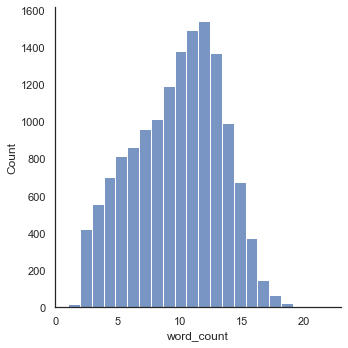

In [22]:
bins = len(set(data['word_count']))
sns.displot(x='word_count', data=data, bins=bins)
plt.tight_layout();

> There are no more than twenty-two words per row. I'll use this information to choose the maximum length of sequences when vectorize the text.

## Preparing the data

In [23]:
X = data.loc[:, ['text']]
y = data['sentiment']

In [24]:
# Split data into 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=0)

# Check dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10980, 1), (10980,), (3660, 1), (3660,))

## Transforming text into vectors

In [25]:
params = {
    'tokenizer': {'num_words': None,
                  'oov_token': '<OOV>'},
    'pad_sequences': {'maxlen': 20,
                      'padding': 'post',
                      'truncating': 'post'},
}

tokenizer = Tokenizer(**params['tokenizer'])
tokenizer.fit_on_texts(X_train['text'].values)
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train['text'].values)
X_train_padded = pad_sequences(X_train_sequences, **params['pad_sequences'])

X_test_sequences = tokenizer.texts_to_sequences(X_test['text'].values)
X_test_padded = pad_sequences(X_test_sequences, **params['pad_sequences'])

## Preparing labels

In [26]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test  = le.fit_transform(y_test)

target_names = le.classes_

In [27]:
# Sanity check
print(X_train_padded.shape, y_train.shape, X_test_padded.shape, y_test.shape, target_names)

(10980, 20) (10980,) (3660, 20) (3660,) ['negative' 'neutral' 'positive']


## Training and evaluating the model

In [28]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping('val_accuracy', patience=10, verbose=1, 
                                     restore_best_weights=True)
]

class_weight_ = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight_

array([0.53166764, 1.57487091, 2.06546275])

In [29]:
vocab_size = len(word_index) + 1
embedding_dim = 64

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                       input_length=X_train_padded.shape[1]),

             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                           embedding_dim,
                                           dropout=0.4,
                                           recurrent_dropout=0.4,
                                           return_sequences=True
                                           )),

             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                           embedding_dim,
                                            dropout=0.4,
                                            recurrent_dropout=0.4
                                            )),
             tf.keras.layers.Dense(64, activation='relu'),
             tf.keras.layers.Dropout(0.25),
             tf.keras.layers.Dense(3, activation='softmax'),
])

classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 64)            663488    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 836,803
Trainable params: 836,803
Non-trainable params: 0
__________________________________________________

In [30]:
%%time
history = classifier.fit(
    X_train_padded, 
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=callbacks, 
    validation_split=0.2,
    class_weight=class_weight_, # inbalaced data
    workers=4,
    use_multiprocessing=True);

Train on 8784 samples, validate on 2196 samples
Epoch 1/100
8784/8784 [==============================] - 45s 5ms/sample - loss: 0.7076 - accuracy: 0.7083 - val_loss: 0.5662 - val_accuracy: 0.7864
Epoch 2/100
8784/8784 [==============================] - 36s 4ms/sample - loss: 0.4797 - accuracy: 0.8288 - val_loss: 0.6114 - val_accuracy: 0.7714
Epoch 3/100
8784/8784 [==============================] - 35s 4ms/sample - loss: 0.3168 - accuracy: 0.8871 - val_loss: 0.6467 - val_accuracy: 0.7760
Epoch 4/100
8768/8784 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9142
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
8784/8784 [==============================] - 36s 4ms/sample - loss: 0.2558 - accuracy: 0.9140 - val_loss: 0.8431 - val_accuracy: 0.7559
Epoch 5/100
8784/8784 [==============================] - 36s 4ms/sample - loss: 0.1647 - accuracy: 0.9469 - val_loss: 0.9205 - val_accuracy: 0.7632
Epoch 6/100
8784/8784 [======================

## Plotting the results

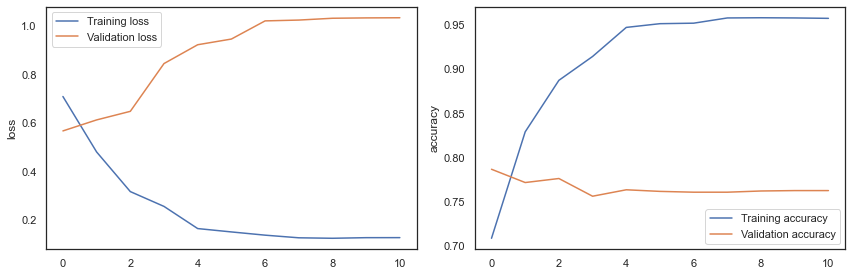

In [31]:
hist = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x=hist.index, y='loss', data=hist,
             label='Training loss', ax=ax[0])

sns.lineplot(x=hist.index, y='val_loss', data=hist,
             label='Validation loss', ax=ax[0])

sns.lineplot(x=hist.index, y='accuracy', 
             data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', 
             data=hist, label='Validation accuracy', ax=ax[1])
             
plt.tight_layout();

In [32]:
loss, accuracy = classifier.evaluate(X_test_padded, y_test, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 76.50%


## Predictions

In [33]:
preds = classifier.predict(X_test_padded, batch_size=256).argmax(axis=1)
print(preds[:10])

[1 2 0 1 1 0 0 0 0 0]


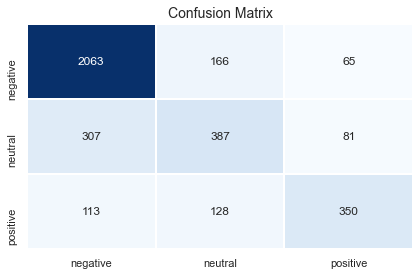

In [34]:
sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',            
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout();

In [35]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      2294
     neutral       0.57      0.50      0.53       775
    positive       0.71      0.59      0.64       591

    accuracy                           0.77      3660
   macro avg       0.70      0.66      0.68      3660
weighted avg       0.76      0.77      0.76      3660



# Using a pretrained GloVe word embeddings
---

## Preprocessing the embeddings

In [36]:
%%time
# Parse the GloVe word-embeddings file
embeddings_index = {}

with open('glove.twitter.27B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word   = values[0]
        coefs  = np.array(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')
print('---')

# Prepare the GloVe word-embeddings matrix
vocab_size    = len(word_index) + 1
embedding_dim = 100

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(f'Embeddings matrix dimensions: {embeddings_matrix.shape}')

Found 1193514 word vectors.
---
Embeddings matrix dimensions: (10367, 100)
Wall time: 39.7 s


## Training the model with a pretrained word embeddings

In [37]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  input_length=X_train_padded.shape[1],
                                  weights=[embeddings_matrix],
                                  trainable=False),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      embedding_dim,
                                      dropout=0.25,
                                      recurrent_dropout=0.25,
                                      return_sequences=True
                                      )),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      embedding_dim,
                                      dropout=0.10,
                                      recurrent_dropout=0.10
                                      )),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1036700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 200)           160800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12864     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,451,359
Trainable params: 414,659
Non-trainable params: 1,036,700
_________________________________________________________________


In [38]:
%%time
history =model.fit(
    X_train_padded, 
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=callbacks, 
    validation_split=0.2,
    class_weight=class_weight_, # inbalaced data
    workers=4,
    use_multiprocessing=True);

Train on 8784 samples, validate on 2196 samples
Epoch 1/100
8784/8784 [==============================] - 42s 5ms/sample - loss: 0.6606 - accuracy: 0.7327 - val_loss: 0.5565 - val_accuracy: 0.7769
Epoch 2/100
8784/8784 [==============================] - 34s 4ms/sample - loss: 0.5495 - accuracy: 0.7827 - val_loss: 0.5137 - val_accuracy: 0.7955
Epoch 3/100
8784/8784 [==============================] - 33s 4ms/sample - loss: 0.4975 - accuracy: 0.8018 - val_loss: 0.5137 - val_accuracy: 0.7910
Epoch 4/100
8784/8784 [==============================] - 34s 4ms/sample - loss: 0.4644 - accuracy: 0.8119 - val_loss: 0.5937 - val_accuracy: 0.7372
Epoch 5/100
8768/8784 [============================>.] - ETA: 0s - loss: 0.4453 - accuracy: 0.8179
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
8784/8784 [==============================] - 34s 4ms/sample - loss: 0.4452 - accuracy: 0.8179 - val_loss: 0.5926 - val_accuracy: 0.7928
Epoch 6/100
8784/8784 [======================

## Evaluating the model

In [39]:
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 78.55%


## Plotting the results

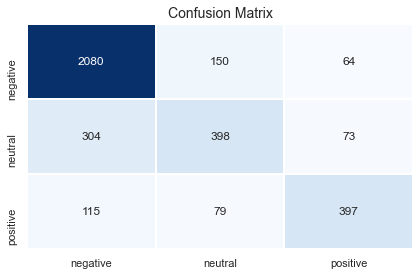

In [40]:
preds = model.predict(X_test_padded, batch_size=256).argmax(axis=1)

sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',            
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout();

In [41]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.83      0.91      0.87      2294
     neutral       0.63      0.51      0.57       775
    positive       0.74      0.67      0.71       591

    accuracy                           0.79      3660
   macro avg       0.74      0.70      0.71      3660
weighted avg       0.78      0.79      0.78      3660



References:   

[Reproducible Results With Keras](https://deeplizard.com/learn/video/HcW0DeWRggs)   
[Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html)

